# Interpretation 3A: KAN Compiler for PDE


In scientific applications, we sometimes know empirical formulas or approximate solutions, represented as symbolic formulas. It would be nice to initialize the KAN network to be the approximate solution, and then fine tune the KAN network. 

In this notebook, We aim to solve a 2D poisson equation $\nabla^2 f(x,y) = -2\pi^2({\rm sin}(\pi x){\rm sin}(\pi y) + 4\epsilon\ {\rm sin}(2\pi x){\rm sin}(2\pi y))$, with boundary condition $f(-1,y)=f(1,y)=f(x,-1)=f(x,1)=0$. The ground truth solution is $f(x,y)={\rm sin}(\pi x){\rm sin}(\pi y)+\epsilon\ {\rm sin}(2\pi x){\rm sin}(2\pi y)$. We set $\epsilon$ to be a small number, and assume to know the approximate solution $f\approx f_{\rm approx}={\rm sin}(\pi x){\rm sin}(\pi y)$.

saving model version 0.1


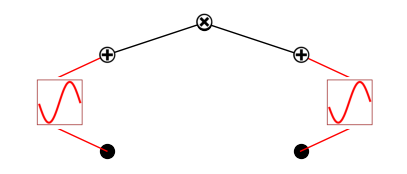

In [1]:
from kan.compiler import kanpiler
from sympy import *
from kan.utils import create_dataset
import torch

input_variables = x,y = symbols('x y')
expr = sin(pi*x) * sin(pi*y) #+ 0.01 * sin(2*pi*x) * sin(2*pi*y)

model = kanpiler(input_variables, expr, grid=5)

x = torch.rand(100,2) * 2 - 1
model.get_act(x)

model.plot()

saving model version 0.2


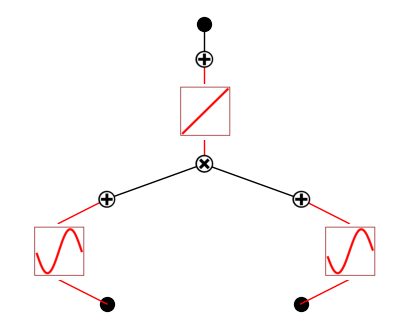

In [2]:
model.expand_depth()
model.get_act(x)
model.plot()

saving model version 0.3


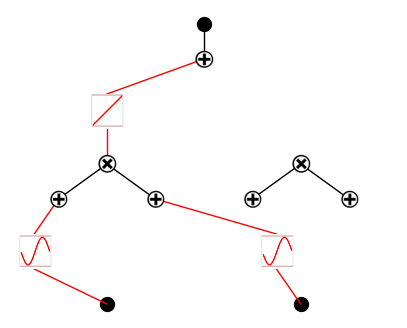

In [3]:
model.expand_width(1, 1, sum_bool=False)
model.get_act(x)
model.plot()

saving model version 0.4


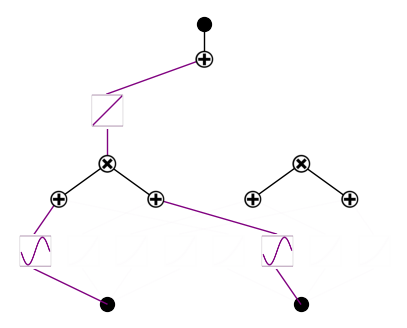

In [4]:
model.perturb(mag=0.01, mode='all')
model.get_act(x)
model.plot(metric='forward_n')
# purple means both symbolic front (red) and spline front (black) are active

In [7]:
from kan import *
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

dim = 2
np_i = 21 # number of interior points (along each dimension)
np_b = 21 # number of boundary points (along each dimension)
ranges = [-1, 1]

#mode = 'fine_tune'
mode = 'from_scratch'

if mode == 'from_scratch':
    model = KAN(width=[2,[0,2],1], grid=5, k=3, seed=3)
else:
    # use the model defined above
    pass

def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# define solution
epsilon = 0.01
sol_fun = lambda x: torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]]) + epsilon * torch.sin(2*torch.pi*x[:,[0]])*torch.sin(2*torch.pi*x[:,[1]])
source_fun = lambda x: -2*torch.pi**2 * (torch.sin(torch.pi*x[:,[0]])*torch.sin(torch.pi*x[:,[1]]) + 4 * epsilon * torch.sin(2*torch.pi*x[:,[0]])*torch.sin(2*torch.pi*x[:,[1]]))

# interior
sampling_mode = 'mesh' # 'ranndom' or 'mesh'

x_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
y_mesh = torch.linspace(ranges[0],ranges[1],steps=np_i)
X, Y = torch.meshgrid(x_mesh, y_mesh, indexing="ij")
if sampling_mode == 'mesh':
    #mesh
    x_i = torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
else:
    #random
    x_i = torch.rand((np_i**2,2))*2-1

# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1,0)
xb1 = helper(X[0], Y[0])
xb2 = helper(X[-1], Y[0])
xb3 = helper(X[:,0], Y[:,0])
xb4 = helper(X[:,0], Y[:,-1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0)

steps = 2001
alpha = 0.01
log = 1

def train():
    
    l2s = []
    
    #optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
    if mode == 'from_scratch':
        lr = 1e-2
    if mode == 'fine_tune':
        lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    pbar = tqdm(range(steps), desc='description', ncols=100)

    for _ in pbar:
        
        
        def closure():
            global pde_loss, bc_loss
            optimizer.zero_grad()
            # interior loss
            sol = sol_fun(x_i)
            sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:,0,:]
            sol_D1 = sol_D1_fun(x_i)
            sol_D2 = batch_jacobian(sol_D1_fun, x_i, create_graph=True)[:,:,:]
            lap = torch.sum(torch.diagonal(sol_D2, dim1=1, dim2=2), dim=1, keepdim=True)
            source = source_fun(x_i)
            pde_loss = torch.mean((lap - source)**2)

            # boundary loss
            bc_true = sol_fun(x_b)
            bc_pred = model(x_b)
            bc_loss = torch.mean((bc_pred-bc_true)**2)

            loss = alpha * pde_loss + bc_loss
            loss.backward()
            return loss

        if _ % 50 == 0 and _ < 500:
            model.update_grid_from_samples(x_i)

        optimizer.step(closure)
        sol = sol_fun(x_i)
        loss = alpha * pde_loss + bc_loss
        l2 = torch.mean((model(x_i) - sol)**2)
        l2s.append(l2.item())

        if _ % log == 0:
            pbar.set_description("pde loss: %.2e | bc loss: %.2e | l2: %.2e " % (pde_loss.cpu().detach().numpy(), bc_loss.cpu().detach().numpy(), l2.detach().numpy()))

    return l2s
    
    
if mode == 'fine_tune':
    l2s_fine_tune = train()
if mode == 'from_scratch':
    l2s_from_scratch = train()

checkpoint directory created: ./model
saving model version 0.0


pde loss: 2.16e-01 | bc loss: 1.21e-04 | l2: 6.99e-05 : 100%|███| 2001/2001 [02:03<00:00, 16.24it/s]


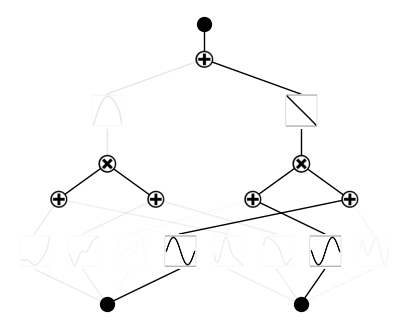

In [8]:
model.plot()
if mode == 'fine_tune':
    plt.savefig('./pde_fine_tune.pdf', bbox_inches='tight', dpi=200)
if mode == 'from_scratch':
    plt.savefig('./pde_from_scratch.pdf', bbox_inches='tight', dpi=200)

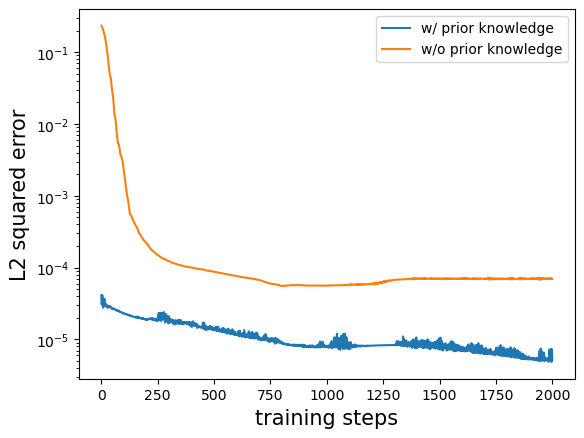

In [13]:
plt.plot(l2s_fine_tune)
plt.plot(l2s_from_scratch)
plt.yscale('log')
plt.legend(['w/ prior knowledge', 'w/o prior knowledge'])
plt.ylabel('L2 squared error', fontsize=15)
plt.xlabel('training steps', fontsize=15)
plt.savefig('./pde_loss.pdf', bbox_inches='tight', dpi=200)